In [1]:
pip install cartopy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


Total PV potential in Pingzhen District: 323.62 MW


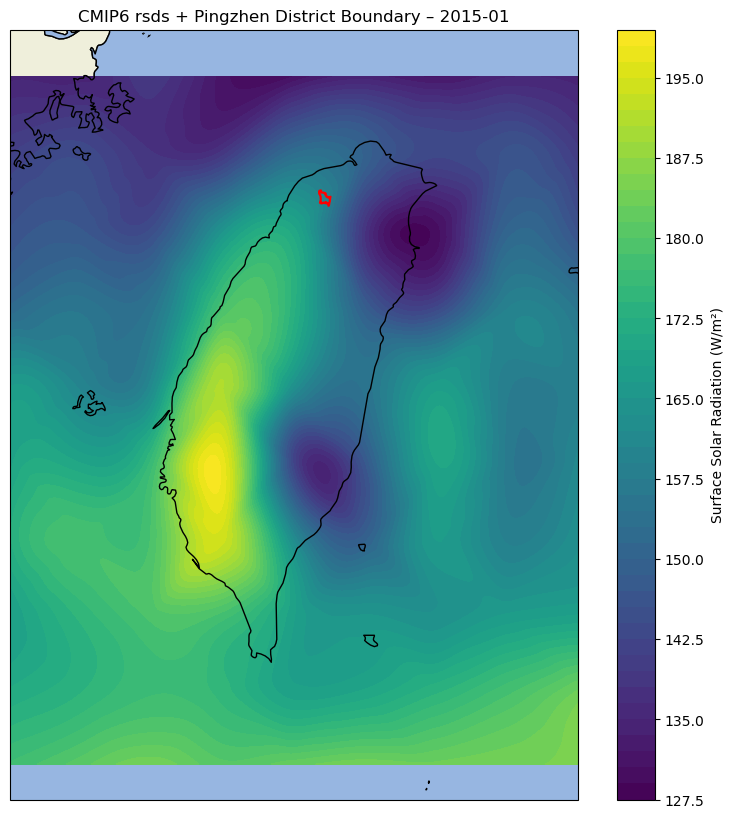

In [3]:
# ======================================
# Calculate total rsds PV potential for 麥寮鄉 (Mailiao Township)
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\rsds_radiation_CNRM_CM6_1_HR_ssp585_2015_2099_new.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
target_month = "2015-01"
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month]

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 300
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 3. Load township shapefile and select 麥寮鄉
# --------------------------------------
file_path = r"C:\Users\User\Downloads\鄉(鎮、市、區)界線1140318\TOWN_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# Filter for 麥寮鄉 (Mailiao Township)
target_county = '桃園市'
target_town = '平鎮區'
town_row = gdf[(gdf['COUNTYNAME'] == target_county) & (gdf['TOWNNAME'] == target_town)]

if town_row.empty:
    raise ValueError("Target town not found in shapefile. Check spelling or field names.")

# Get geometry and English name
town_geom = town_row.geometry.iloc[0]
target_town_eng = town_row['TOWNENG'].iloc[0]

# --------------------------------------
# 4. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 5. Calculate total PV potential within township boundary
# --------------------------------------
efficiency = 0.15    # PV panel efficiency
panel_ratio = 0.3    # land usage ratio

total_potential = 0

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        if masked_rsds[i,j] is ma.masked:
            continue
        point = Point(lon2d[i,j], lat2d[i,j])
        if town_geom.contains(point):
            rsds = masked_rsds[i,j]  # W/m²
            area = cell_areas[i,j]   # m²
            potential = rsds * area * efficiency * panel_ratio  # W
            total_potential += potential

# Convert to MW
total_potential_MW = total_potential / 1e6

# --------------------------------------
# 6. Print results
# --------------------------------------
print(f"Total PV potential in {target_town_eng}: {total_potential_MW:.2f} MW")

# --------------------------------------
# 7. Plot to visualize township overlay with English name
# --------------------------------------
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Plot CMIP6 rsds contour
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# Plot township boundary
ax.add_geometries([town_geom], crs=ccrs.PlateCarree(),
                  edgecolor='red', facecolor='none', linewidth=1.5)

# Add map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Colorbar and title with English township name
plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
plt.title(f"CMIP6 rsds + {target_town_eng} Boundary – {target_month}")
plt.show()


Total PV potential in Mailiao Township: 747.53 MW


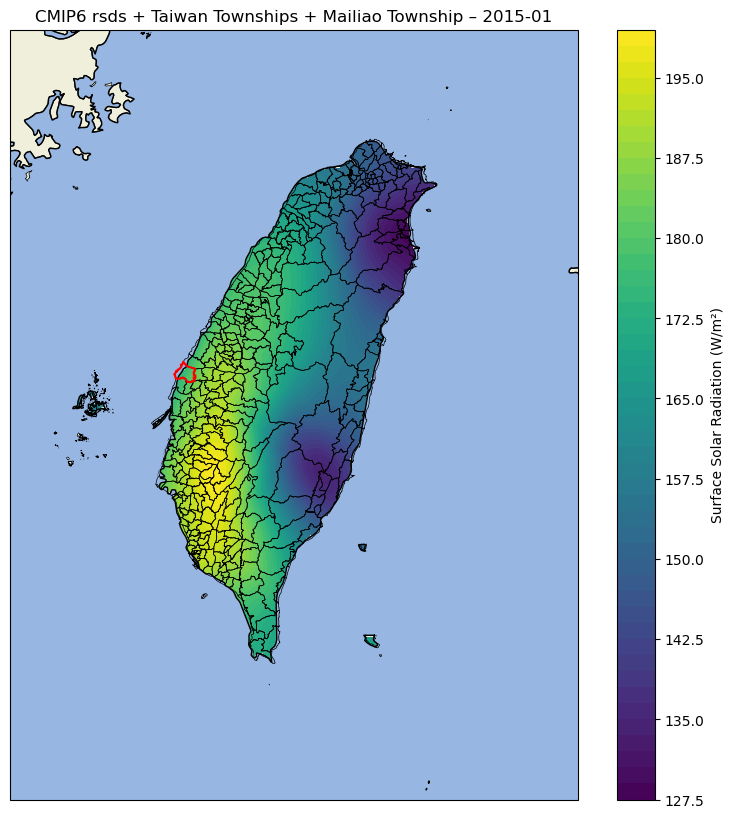

In [4]:
# ======================================
# CMIP6 rsds contour + Taiwan township boundaries + PV potential calculation
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\rsds_radiation_CNRM_CM6_1_HR_ssp585_2015_2099_new.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
target_month = "2015-01"
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month]

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 300
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 3. Create mask using Taiwan geometry (Natural Earth)
# --------------------------------------
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

taiwan_geom = None
for country in countries:
    if country.attributes['NAME_LONG'] == 'Taiwan':
        taiwan_geom = country.geometry
        break

# Create mask: True where outside Taiwan
mask = np.ones(grid_rsds.shape, dtype=bool)
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        point = Point(lon2d[i, j], lat2d[i, j])
        if taiwan_geom.intersects(point):
            mask[i, j] = False

masked_rsds = ma.masked_array(grid_rsds, mask)

# --------------------------------------
# 4. Load township shapefile
# --------------------------------------
file_path = r"C:\Users\User\Downloads\鄉(鎮、市、區)界線1140318\TOWN_MOI_1140318.shp"
gdf = gpd.read_file(file_path)

# Reproject to EPSG:4326 if needed
if gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# --------------------------------------
# 5. Select target township for PV calculation
# --------------------------------------
target_county = '雲林縣'
target_town = '麥寮鄉'
town_row = gdf[(gdf['COUNTYNAME'] == target_county) & (gdf['TOWNNAME'] == target_town)]

if town_row.empty:
    raise ValueError("Target town not found in shapefile. Check spelling or field names.")

town_geom = town_row.geometry.iloc[0]
target_town_eng = town_row['TOWNENG'].iloc[0]

# --------------------------------------
# 6. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 7. Calculate total PV potential within township
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3
total_potential = 0

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        if masked_rsds[i,j] is ma.masked:
            continue
        point = Point(lon2d[i,j], lat2d[i,j])
        if town_geom.contains(point):
            rsds = masked_rsds[i,j]  # W/m²
            area = cell_areas[i,j]   # m²
            potential = rsds * area * efficiency * panel_ratio  # W
            total_potential += potential

# Convert to MW
total_potential_MW = total_potential / 1e6
print(f"Total PV potential in {target_town_eng}: {total_potential_MW:.2f} MW")

# --------------------------------------
# 8. Plotting combined contour + township boundaries
# --------------------------------------
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Base map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# CMIP6 rsds contour
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# Township boundaries overlay
for _, row in gdf.iterrows():
    geom = row.geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', linewidth=0.5)

# Highlight target township in red
ax.add_geometries([town_geom], crs=ccrs.PlateCarree(),
                  edgecolor='red', facecolor='none', linewidth=1.5)

# Colorbar and title
plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
plt.title(f"CMIP6 rsds + Taiwan Townships + {target_town_eng} – {target_month}")
plt.show()
